In [1]:
import pandas as pd
import numpy as np
import sklearn
import plotly.express as px
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import random
import sys

current_dir = os.getcwd()

parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from preprocessing import DATA_ROOT, DATA_FOLDERS, DATA_SUBFOLDERS, SEGMENTATION_FILES, SEGMENTATION_NAMES 

from preprocessing import load_labels, image_generator, image_path_generator, batch_generator, load_segmentation, merge_dicts


# Should look like _______ MATH4570-final-project-1\Preprocessing
# unzip the contents of the OneDrive folder into the parent directory of the git repo.
# so the 3 files should be renders, dcms (empty), hemhorrage-labels
print(os.getcwd())

C:\Users\johnn\MATH4570-final-project-1


In [2]:
df = pd.read_csv("../hemorrhage-labels.csv", index_col="Image")
labels_dict = load_labels("../Hemorrhage Segmentation Project")

In [3]:
labels_dict["ID_ffff82e46"]

{'any': 0,
 'epidural': 0,
 'intraparenchymal': 0,
 'intraventricular': 0,
 'subarachnoid': 0,
 'subdural': 0}

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.layers import Conv2D 

NUM_LABELS = 5

def build_model():
    model = Sequential()
    model.add(Conv2D(32, (11,11),
                     padding='valid',
                     input_shape=(128, 128, 1),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64, (9,9),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (5,5),
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=NUM_LABELS, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model
build_model().summary()

C:\Users\johnn\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 118, 118, 32)   │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 51, 51, 64)     │       165,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,653,125 (13.94 MB)

 Trainable params: 3,653,125 (13.94 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
#1694
epi_batch_gen = batch_generator('C:/Users/johnn/Downloads/XN_Project/XN_Project/renders/epidural/epidural/brain_window', 
                            batch_size=100)
#15664
intraparenchymal_batch_gen = batch_generator('C:/Users/johnn/Downloads/XN_Project/XN_Project/renders/intraparenchymal/intraparenchymal/brain_window', 
                            batch_size=450)
#9878
intraventricular_batch_gen = batch_generator('C:/Users/johnn/Downloads/XN_Project/XN_Project/renders/intraventricular/intraventricular/brain_window', 
                            batch_size=350)
#16423
subarachnoid_batch_gen = batch_generator('C:/Users/johnn/Downloads/XN_Project/XN_Project/renders/subarachnoid/subarachnoid/brain_window', 
                            batch_size=100)
#32074
multi_batch_gen = batch_generator('C:/Users/johnn/Downloads/XN_Project/XN_Project/renders/multi/multi/brain_window', 
                            batch_size=500)

(100, 512, 512, 3)


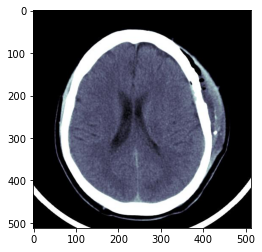

In [6]:
imgs, labels = next(epi_batch_gen)

plt.imshow(imgs[0])
print(imgs.shape)

In [7]:
gs_imgs = np.dot(imgs[...,:3], [0.2125 , 0.7154 , 0.0721 ])
gs_imgs.shape

(100, 512, 512)

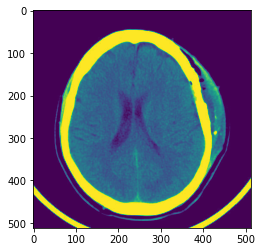

In [8]:
plt.imshow(gs_imgs[0])

Now we train the model on batches, we treat each batch as an epoch and we train on 9/10 of the batch, testing on the final 1/10

In [9]:
import tensorflow as tf
from tensorflow import keras

def shrink(image, label):
    resized_image = tf.image.resize(image, [128, 128])
    gs_image = tf.image.rgb_to_grayscale(resized_image)
    final_image = keras.applications.xception.preprocess_input(gs_image)
    return final_image, label

windows = ['brain_window', 'subdural_window', 'max_contrast_window', 'brain_bone_window']

for window in windows:
    model = build_model()
    #1694
    epi_batch_gen = batch_generator('C:/Users/johnn/Downloads/XN_Project/XN_Project/renders/epidural/epidural/' + window, 
                                batch_size=100)
    #15664
    intraparenchymal_batch_gen = batch_generator('C:/Users/johnn/Downloads/XN_Project/XN_Project/renders/intraparenchymal/intraparenchymal/' + window, 
                                batch_size=450)
    #9878
    intraventricular_batch_gen = batch_generator('C:/Users/johnn/Downloads/XN_Project/XN_Project/renders/intraventricular/intraventricular/' + window, 
                                batch_size=350)
    #16423
    subarachnoid_batch_gen = batch_generator('C:/Users/johnn/Downloads/XN_Project/XN_Project/renders/subarachnoid/subarachnoid/' + window, 
                                batch_size=100)
    #32074
    #multi_batch_gen = batch_generator('C:/Users/johnn/Downloads/XN_Project/XN_Project/renders/multi/multi/brain_window', 
    #                            batch_size=500)

    print('Results for ' + window)

    batch_size = 1000

    epochs = 10

    for epoch in range(epochs):
        epi_images, epi_ids = next(epi_batch_gen)
        intraparenchymal_images, intraparenchymal_ids = next(intraparenchymal_batch_gen)
        intraventricular_images, intraventricular_ids = next(intraventricular_batch_gen)
        subarachnoid_images, subarachnoid_ids = next(subarachnoid_batch_gen)
        #multi_images, multi_ids = next(multi_batch_gen)
        #subdural_images, subdural_ids = next(subdural_batch_gen)

        images = np.concatenate([epi_images, intraparenchymal_images, intraventricular_images, subarachnoid_images])
        ids = np.concatenate([epi_ids, intraparenchymal_ids, intraventricular_ids, subarachnoid_ids])

        p = np.random.permutation(len(images))
        images = images[p]
        ids = ids[p]

        Y_train = np.array([])
        X_train = images[0:int(0.8*batch_size)]
        Y_test = np.array([])
        X_test = images[int(0.8*batch_size):]
        X_train = X_train / 255
        X_test = X_test / 255

        for i, (img, file_id) in enumerate(zip(images[0:int(0.8*batch_size)], ids[0:int(0.8*batch_size)])):
            temp = []
            if (labels_dict[file_id]['any'] == 0):
                temp = [1]
            else:
                temp = [0]
            Y_train = np.append(Y_train, np.append(temp, np.fromiter(labels_dict[file_id].values(), dtype=float)[1:5]))

        for i, (img, file_id) in enumerate(zip(images[int(0.8*batch_size):], ids[int(0.8*batch_size):])):
            temp = []
            if (labels_dict[file_id]['any'] == 0):
                temp = [1]
            else:
                temp = [0]
            Y_test = np.append(Y_test, np.append(temp, np.fromiter(labels_dict[file_id].values(), dtype=float)[1:5]))

        Y_train = Y_train.reshape(-1, 5)
        Y_test = Y_test.reshape(-1, 5)

        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).map(shrink).batch(30).prefetch(1)
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).map(shrink).batch(30).prefetch(1)
        history = model.fit(train_dataset,
                        verbose=1,
                        validation_data=test_dataset)


Results for brain_window
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 372ms/step - accuracy: 0.3932 - loss: 1.8827 - val_accuracy: 0.4350 - val_loss: 1.2405
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 395ms/step - accuracy: 0.4304 - loss: 1.2887 - val_accuracy: 0.4100 - val_loss: 1.1934
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 402ms/step - accuracy: 0.4569 - loss: 1.2438 - val_accuracy: 0.3000 - val_loss: 1.2158
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 424ms/step - accuracy: 0.3462 - loss: 1.2780 - val_accuracy: 0.4600 - val_loss: 1.1986
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 440ms/step - accuracy: 0.4280 - loss: 1.1580 - val_accuracy: 0.4650 - val_loss: 1.2454
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 458ms/step - accuracy: 0.4167 - loss: 1.2082 - val_accuracy: 0.4750 - val_loss: 1.1589
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 427ms/step - accuracy: 0.4440 - loss: 1.2120 - val_accuracy: 0.4850 - val_loss: 1.1616
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 432ms/step - accuracy: 0.4327 - loss: 1.2048 - val_accuracy: 0.5100 - val_loss: 1.1454
27/27 ━━━━━━━━━━━━━━━━━━━━ 17s 

There are 6 classifiable hemorrhages classes (including the no hemorrhage class). Computation cost is quite high for this code so I cannot run images. These results, given batch size and epoch count, seem very promising. With extensive training from the full dataset, I'm assuming we would see quite a strong model.

# Trying a pretrained model

We can give a pretrained model a try:

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
epochs = 10

def get_hem_type(label):
    if (label[0] == 1):
        return 0
    elif (label[1] == 1):
        return 1
    elif (label[2] == 1):
        return 2
    elif (label[3] == 1):
        return 3
    elif (label[4] == 1):
        return 4
    else:
        return 5

def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    hem_label = get_hem_type(label)
    return final_image, hem_label


windows = ['brain_window', 'subdural_window', 'max_contrast_window', 'brain_bone_window']

for window in windows:
    model = build_model()
    #1694
    epi_batch_gen = batch_generator('C:/Users/johnn/Downloads/XN_Project/XN_Project/renders/epidural/epidural/' + window, 
                                batch_size=100)
    #15664
    intraparenchymal_batch_gen = batch_generator('C:/Users/johnn/Downloads/XN_Project/XN_Project/renders/intraparenchymal/intraparenchymal/' + window, 
                                batch_size=450)
    #9878
    intraventricular_batch_gen = batch_generator('C:/Users/johnn/Downloads/XN_Project/XN_Project/renders/intraventricular/intraventricular/' + window, 
                                batch_size=350)
    #16423
    subarachnoid_batch_gen = batch_generator('C:/Users/johnn/Downloads/XN_Project/XN_Project/renders/subarachnoid/subarachnoid/' + window, 
                                batch_size=100)
    #32074
    #multi_batch_gen = batch_generator('C:/Users/johnn/Downloads/XN_Project/XN_Project/renders/multi/multi/brain_window', 
    #                            batch_size=500)

    print('Results for ' + window)

    batch_size = 1000

    epochs = 10

    base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
    avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    output = tf.keras.layers.Dense(5, activation="softmax")(avg)
    pretrained_model = tf.keras.Model(inputs=base_model.input, outputs=output)

    pretrained_model.summary()

    for layer in base_model.layers:
        layer.trainable = False

    #optimizer = tf.keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
    pretrained_model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    for epoch in range(epochs):
        epi_images, epi_ids = next(epi_batch_gen)
        intraparenchymal_images, intraparenchymal_ids = next(intraparenchymal_batch_gen)
        intraventricular_images, intraventricular_ids = next(intraventricular_batch_gen)
        subarachnoid_images, subarachnoid_ids = next(subarachnoid_batch_gen)
        #multi_images, multi_ids = next(multi_batch_gen)
        #subdural_images, subdural_ids = next(subdural_batch_gen)

        images = np.concatenate([epi_images, intraparenchymal_images, intraventricular_images, subarachnoid_images])
        ids = np.concatenate([epi_ids, intraparenchymal_ids, intraventricular_ids, subarachnoid_ids])

        p = np.random.permutation(len(images))
        images = images[p]
        ids = ids[p]

        Y_train = np.array([])
        X_train = images[0:int(0.8*batch_size)]
        Y_test = np.array([])
        X_test = images[int(0.8*batch_size):]
        X_train = X_train / 255
        X_test = X_test / 255

        for i, (img, file_id) in enumerate(zip(images[0:int(0.8*batch_size)], ids[0:int(0.8*batch_size)])):
            temp = []
            if (labels_dict[file_id]['any'] == 0):
                temp = [1]
            else:
                temp = [0]
            Y_train = np.append(Y_train, np.append(temp, np.fromiter(labels_dict[file_id].values(), dtype=float)[1:5]))

        for i, (img, file_id) in enumerate(zip(images[int(0.8*batch_size):], ids[int(0.8*batch_size):])):
            temp = []
            if (labels_dict[file_id]['any'] == 0):
                temp = [1]
            else:
                temp = [0]
            Y_test = np.append(Y_test, np.append(temp, np.fromiter(labels_dict[file_id].values(), dtype=float)[1:5]))

        Y_train = Y_train.reshape(-1, 5)
        Y_test = Y_test.reshape(-1, 5)

        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).map(preprocess).batch(30).prefetch(1)
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).map(preprocess).batch(30).prefetch(1)

        history = pretrained_model.fit(train_dataset, epochs=1, validation_data=test_dataset)

C:\Users\johnn\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Results for brain_window


Model: "functional_73"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │        864 │ input_layer_6[0]… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, None,      │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, None,      │          0 │ block1_conv1_bn[… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, None,      │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, None,      │          0 │ block1_conv2_bn[… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, None,      │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, None,      │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, None,      │          0 │ block2_sepconv1_… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, None,      │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, None,      │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, None,      │      8,192 │ block1_conv2_act… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │        512 │ conv2d_18[0][0]   │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None,      │          0 │ block2_pool[0][0… │
│                     │ None, 128)        │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, None,      │          0 │ add[0][0]       

 Total params: 20,871,725 (79.62 MB)

 Trainable params: 20,817,197 (79.41 MB)

 Non-trainable params: 54,528 (213.00 KB)

27/27 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.3779 - loss: 1.4527 - val_accuracy: 0.4400 - val_loss: 1.2852
27/27 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5049 - loss: 1.1981 - val_accuracy: 0.5100 - val_loss: 1.2165
27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5122 - loss: 1.2054 - val_accuracy: 0.4550 - val_loss: 1.1901
27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4861 - loss: 1.1786 - val_accuracy: 0.4850 - val_loss: 1.1563
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.4571 - loss: 1.2200 - val_accuracy: 0.5200 - val_loss: 1.1783
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5038 - loss: 1.1471 - val_accuracy: 0.3900 - val_loss: 1.2818
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5389 - loss: 1.1502 - val_accuracy: 0.5150 - val_loss: 1.1810
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.4925 - loss: 1.1581 - val_accuracy: 0.4700 - val_loss: 1.1974
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5269 - loss: 1.1544 - val_a

Model: "functional_87"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │        864 │ input_layer_8[0]… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, None,      │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, None,      │          0 │ block1_conv1_bn[… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, None,      │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, None,      │          0 │ block1_conv2_bn[… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, None,      │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, None,      │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, None,      │          0 │ block2_sepconv1_… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, None,      │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, None,      │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, None,      │      8,192 │ block1_conv2_act… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        512 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, None,      │          0 │ block2_pool[0][0… │
│                     │ None, 128)        │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, None,      │          0 │ add_12[0][0]    

 Total params: 20,871,725 (79.62 MB)

 Trainable params: 20,817,197 (79.41 MB)

 Non-trainable params: 54,528 (213.00 KB)

27/27 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.3995 - loss: 1.4355 - val_accuracy: 0.4750 - val_loss: 1.1607
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.4838 - loss: 1.2240 - val_accuracy: 0.5150 - val_loss: 1.1811
27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.4862 - loss: 1.1793 - val_accuracy: 0.4800 - val_loss: 1.2106
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.4476 - loss: 1.1941 - val_accuracy: 0.5250 - val_loss: 1.1409
27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.4945 - loss: 1.2065 - val_accuracy: 0.4800 - val_loss: 1.2180
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.4967 - loss: 1.1674 - val_accuracy: 0.4900 - val_loss: 1.1467
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5193 - loss: 1.1531 - val_accuracy: 0.4400 - val_loss: 1.2112
27/27 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5362 - loss: 1.1339 - val_accuracy: 0.5550 - val_loss: 1.0728
27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5094 - loss: 1.1297 - val_a

Model: "functional_101"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │        864 │ input_layer_10[0… │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, None,      │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, None,      │          0 │ block1_conv1_bn[… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, None,      │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, None,      │          0 │ block1_conv2_bn[… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, None,      │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, None,      │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, None,      │          0 │ block2_sepconv1_… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, None,      │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, None,      │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, None,      │      8,192 │ block1_conv2_act… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        512 │ conv2d_32[0][0]   │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, None,      │          0 │ block2_pool[0][0… │
│                     │ None, 128)        │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, None,      │          0 │ add_24[0][0]    

 Total params: 20,871,725 (79.62 MB)

 Trainable params: 20,817,197 (79.41 MB)

 Non-trainable params: 54,528 (213.00 KB)

27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.2037 - loss: 1.5661 - val_accuracy: 0.4700 - val_loss: 1.3366
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.4305 - loss: 1.2886 - val_accuracy: 0.4650 - val_loss: 1.2375
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.4325 - loss: 1.2629 - val_accuracy: 0.4100 - val_loss: 1.2370
27/27 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.4767 - loss: 1.2127 - val_accuracy: 0.4450 - val_loss: 1.2148
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.4471 - loss: 1.1991 - val_accuracy: 0.4300 - val_loss: 1.2276
27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.4510 - loss: 1.2008 - val_accuracy: 0.4800 - val_loss: 1.1800
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.4634 - loss: 1.1689 - val_accuracy: 0.4550 - val_loss: 1.2045
